In [47]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from altaipony.fakeflares import aflare

import os
CWD = "/".join(os.getcwd().split("/")[:-2])

import pytest

from funcs.model import daylength

import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [2]:
 

def on_off(phi, daylength, phi0=0.):
    """Calculate the visibility step function
    of a point on a rotating sphere as a function of
    longitude phi.
    
    phi0 is facing the observer.
    
    Parameters:
    ------------
    phi : array
        longitudes
    daylength : float
        fraction of rotation period (0,1)
    phi0 : float 
        longitude to start with
        default 0
    
    
    """
    # everything is visible by default
    res = np.full(phi.shape[0],1) 
    
    # if longitude is on the night side, set visibility to 0:
    res[((phi-phi0)%(2*np.pi) > daylength*np.pi) & ((phi-phi0)%(2*np.pi) < (2-daylength)*np.pi)] = 0
    
    return res

In [3]:
def lambert(phi,i,l):
    """Calculate Lambert's law of geometric
    brightness modulation (prop. cos(incident angle))
    from known stellar inclination, and the 
    spots latitude and longitudes.
    
    Parameters:
    -----------
    phi : array
        longitudes
    i : float
        inlcination in rad
    l : float
        latitude in rad
        
    Return:
    -------
    Array of values between 0 and 1 that define the 
    fraction of the flux that we would receive from 
    a point at the center of the stellar disk.
    
    Wikipedia is great:
    https://en.wikipedia.org/wiki/Great-circle_distance
    https://en.wikipedia.org/wiki/Lambert%27s_cosine_law
    """
    #print((np.sin(l) * np.cos(i) + np.cos(l) * np.sin(i) * np.cos(phi)).shape)
    
    return np.sin(l) * np.cos(i) + np.cos(l) * np.sin(i) * np.cos(phi)

In [4]:
def great_circle_distance(a, la, b, lb):
    """a, b latitude
    la, lb longitude
    """
    return np.arccos(np.sin(a) * np.sin(b) + np.cos(a) * np.cos(b) * np.cos(la-lb))

def dot_ensemble(lat, lon, radius, num_pts=1e5):
    indices = np.arange(0, num_pts, dtype=float) + 0.5
    phi = np.arccos(1 - 2 * indices/num_pts) #latitude
    theta = np.pi * (1 + 5**0.5) * indices #longitue
    gcs = great_circle_distance(lat, lon,
                                np.pi / 2 - phi % (2 * np.pi),
                                theta % (np.pi * 2))
    a = np.where(gcs < (radius * np.pi / 180))[0]
    phi2 = np.pi/2 - phi[a]%(2*np.pi)
    theta2 = theta[a]%(np.pi*2)
    return phi2, theta2

In [8]:
def model(phi, latitudes, longitudes, flare, inclination):
    """Take a flare light curve and a rotating ensemble of latitudes
    and longitudes, and let it rotate. 
    
    Parameters:
    -----------
    phi :  N-array
        longitudes to evaluate the model at in rad
    latitudes : M-array
        latitudes of the spot grid points in rad
    longitudes : M-array
        longitudes of the spot grid points in rad
    flare : N-array
        flare shape
    inclination : float
        inclination in rad
    """
    l = len(latitudes)
    assert len(latitudes) == len(longitudes)
    latlon = np.concatenate((latitudes.reshape(l,1),
                             longitudes.reshape(l,1)),
                            axis=1)
    
    Ds = daylength(latlon[:,0], inclination)
    onoff = np.full((latlon.shape[0],phi.shape[0]),0)
    
    for i,d in enumerate(Ds):
        onoff[i,:] = on_off(phi-latlon[i,1], d)
        
    A = []
    for i, ll in enumerate(latlon):
        a = lambert(phi-ll[1], I, ll[0])
        A.append(a)
    lamb = np.array(A)
    return lamb, onoff, np.sum(lamb * onoff, axis=0) * flare / l

### Plots 

Text(0, 0.5, 'latitude [deg]')

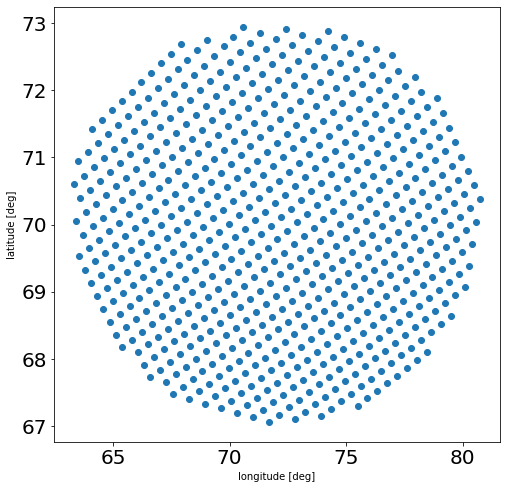

In [63]:
# plot a grid

#latitudes, longitudes = dot_ensemble(np.pi/2-np.pi/8,np.pi/2-np.pi/10,4,num_pts=1e6)
latitudes, longitudes = dot_ensemble(70/180*np.pi,np.pi/2-np.pi/10,3,num_pts=1e6)
plt.figure(figsize=(8,8))
plt.scatter(longitudes/np.pi*180, latitudes/np.pi*180)
#plt.scatter([180/2-180/10],[180/2-180/8],)
plt.xlabel("longitude [deg]")
plt.ylabel("latitude [deg]")
#plt.savefig(f"{CWD}/analysis/plots/model/dot_ensemble.png",dpi=300)

In [64]:
# Plot a model consisting of an ensemble of rotating flaring points on a sphere

I = 71 * np.pi / 180.
phi = np.linspace(0,6*np.pi,2000)
flare = aflare(phi, 3.1, 3., 20,)

lamb, onoff, m = model(phi, latitudes, longitudes, flare, I)

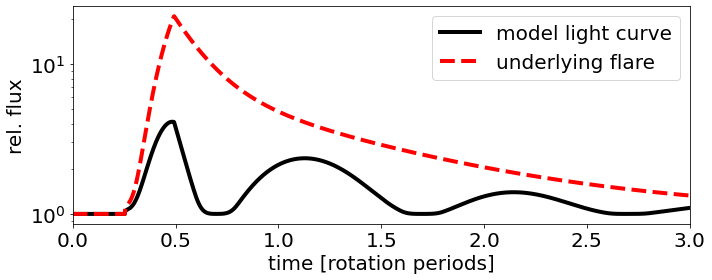

In [66]:
plt.figure(figsize=(10,4))
#for l,oo in zip(lamb,onoff):
#    plt.plot(phi/2/np.pi, l*oo*flare, alpha=.1, c="grey")
plt.plot(phi/2/np.pi,m+1,c="k",linewidth=4, label="model light curve")#,\naverage of individual\ngrid dots (in grey)")
plt.plot(phi/2/np.pi,flare+1, label="underlying flare",c="r",linestyle="dashed",linewidth=4)
plt.xlabel("time [rotation periods]",fontsize=20)
plt.ylabel("rel. flux",fontsize=20)
plt.xlim(0,3)
plt.legend(fontsize=20)
plt.yscale("log")
plt.tight_layout()
#plt.title("Flare with rel. amplitude=5, and FWHM=3.3 rotation periods")
#plt.savefig(f"{CWD}/analysis/plots/model/rotating_flaring_ensemble_lightcurve.png",dpi=300);
plt.savefig(f"{CWD}/analysis/plots/ddt/lightcurve_l70_i71.png",dpi=300);